In [3]:
import random
import numpy as np
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

from simul_util import make_reproducibility, sampling, simulation, MYTensorDataset
from simul_loss import log_t_normalizing_const, gamma_regularizer
from simul_model import Encoder, Decoder, gammaAE

USE_CUDA = torch.cuda.is_available()
DEVICE = torch.device(f'cuda:0' if USE_CUDA else "cpu")

index = 158
K = 2
p_dim = 5
q_dim = 2
nu = 10
recon_sigma = 0.1
nu_list = [5, 2]
N_list = [4000, 1000]
sample_N = 5000
epochs = 120
num_layers = 128
batch_size = 128
make_reproducibility(500)
sample_seed_1 = 100
sample_seed_2 = 200
b_list = [torch.randn(p_dim) for ind in range(K)]
A_list = [torch.randn(p_dim, q_dim) for ind in range(K)]
var_list = [recon_sigma**2 * torch.eye(p_dim) + A @ A.T for A in A_list]
module_type = gammaAE

train_data = simulation(
    DEVICE, p_dim=p_dim, SEED=sample_seed_1,
    K=K, N_list=N_list,
    mu_list=b_list,
    var_list=var_list,
    nu_list=nu_list
)

test_data = simulation(
    DEVICE, p_dim=p_dim, SEED=sample_seed_2,
    K=K, N_list=[800,200],
    mu_list=b_list,
    var_list=var_list,
    nu_list=nu_list
)

train_dataset = MYTensorDataset(train_data)

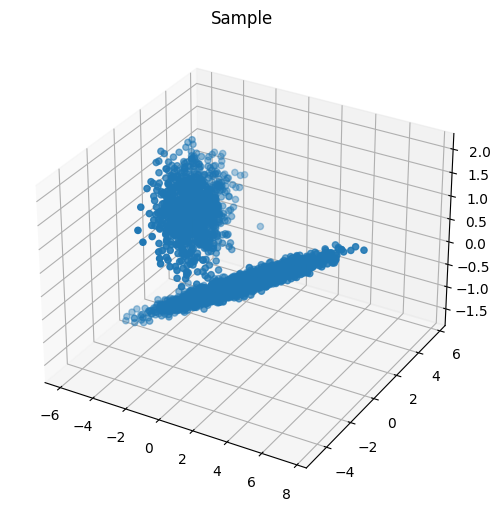

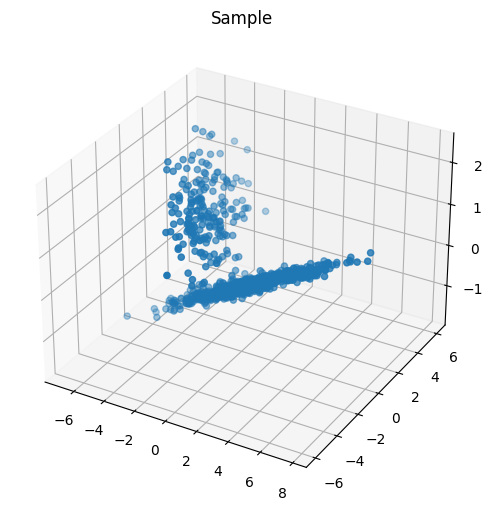

In [7]:
import matplotlib.pyplot as plt
from simul_visualize import visualize_2D, visualize_3D, visualize_PCA, total_visualize_2D, total_visualize_3D, total_visualize_PCA

if p_dim == 2 : 
    visualize_2D(train_data).show()
    visualize_2D(test_data).show()
elif p_dim == 3 : 
    visualize_3D(train_data).show()
    visualize_3D(test_data).show()
else  : 
    visualize_PCA(train_data).show()
    visualize_PCA(test_data).show()

In [122]:
gAE = module_type(simulation_trainset, p_dim, q_dim, nu, DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)
VAE = module_type(simulation_trainset, p_dim, q_dim, 0 , DEVICE, num_layers = num_layers, recon_sigma = recon_sigma, batch_size = batch_size)

epoch_tqdm = tqdm(range(0, epochs))
for epoch in epoch_tqdm : 
    # print(f'\nEpoch {epoch}')
    gAE.train(epoch)
    VAE.train(epoch)

100%|██████████| 120/120 [03:17<00:00,  1.64s/it]


In [123]:
MVT_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), nu, DEVICE)
MVN_prior = sampling(sample_N, torch.zeros(q_dim), torch.eye(q_dim), 0, DEVICE)

gAE_reconstruction = gAE.decoder.sampling(gAE.encoder(t_sample)[0]).detach().cpu().numpy()
VAE_reconstruction = VAE.decoder.sampling(VAE.encoder(t_sample)[0]).detach().cpu().numpy()

gAE_sample = gAE.decoder.sampling(MVT_prior).detach().cpu().numpy()
VAE_sample = VAE.decoder.sampling(MVN_prior).detach().cpu().numpy()

In [124]:
# print(gAE.decoder.fc.weight)
# print(A)

# print(gAE.decoder.fc.bias)
# print(b)

# print(gAE.encoder.latent_mu.weight)
# print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)))

# print(gAE.encoder.latent_mu.bias)
# print(A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ b)

# x_sample = sampling(1000, torch.zeros(p_dim), torch.eye(p_dim), 0, DEVICE)
# var_recon = torch.exp(gAE.encoder.latent_var(x_sample))

# def true_var(x, p_dim, q_dim, A, b, nu, recon_sigma) : 
#     term1 = (nu + (x - b).T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ (x - b)) / (nu + p_dim)
#     term2 = torch.eye(q_dim) - A.T @ torch.linalg.inv(A @ A.T + recon_sigma**2 * torch.eye(p_dim)) @ A
#     return term1 * term2

# true_var_list = [
#     true_var(x.cpu(), p_dim, q_dim, A, b, nu, recon_sigma) for x in x_sample
# ]
# torch.as_tensor(true_var_list).unsqueeze(1).shape
# torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1)

# visualize_3D(torch.cat([x_sample, var_recon], axis = 1).detach()).show()

# visualize_3D(torch.cat([x_sample, torch.as_tensor(true_var_list).to(DEVICE).unsqueeze(1)], axis = 1).detach()).show()


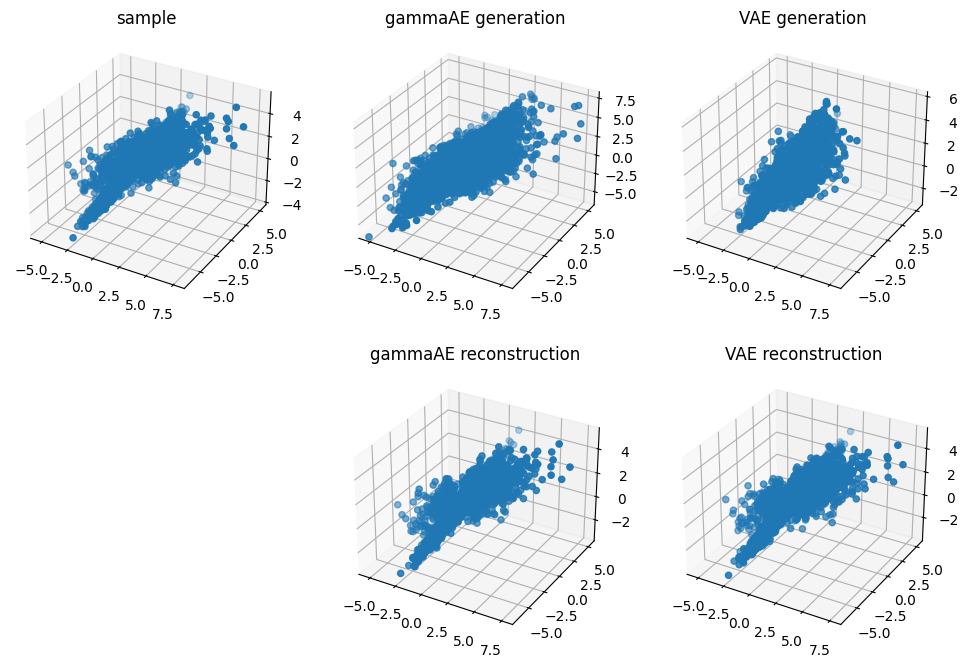

In [125]:
if p_dim == 2 : 
    figure = total_visualize_2D(t_sample, gAE_reconstruction, gAE_sample, VAE_reconstruction, VAE_sample)
    figure.show()
    # figure.savefig(f"Result_{index}.jpg")
elif p_dim == 3: 
    figure = total_visualize_3D(t_sample, gAE_reconstruction, gAE_sample, VAE_reconstruction, VAE_sample)
    figure.show()
    # figure.savefig(f"Result_{index}.jpg")

In [126]:
from mmd import mmd_penalty

mmd_gAE = mmd_penalty(torch.as_tensor(gAE_sample), t_sample.cpu())
mmd_VAE = mmd_penalty(torch.as_tensor(VAE_sample), t_sample.cpu())
print(mmd_gAE)
print(mmd_VAE)
if mmd_gAE < mmd_VAE : 
    figure.savefig(f"Result_{index}.jpg")

tensor(0.0111)
tensor(0.0038)
